In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
import requests
import collections
from torch.nn import functional as F
import re
# import time
import math
import random
import nltk
from sklearn.manifold import TSNE
from nltk.stem import WordNetLemmatizer
from torch.utils import data
import hashlib
import os
nltk.download('punkt')
print(torch.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2.0.0+cu118


(1.0, 1000.0)

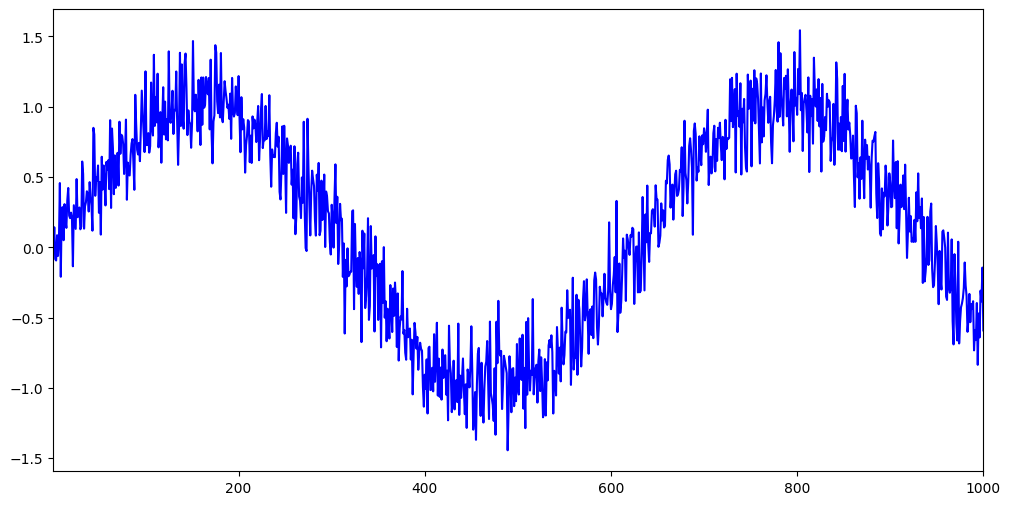

In [ ]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(12, 6))
plt.plot(time, x, '-b')
plt.xlim(1, 1000)

In [ ]:
def generate_date(tau):
    features = torch.zeros((T - tau, tau))
    for i in range(tau):
        features[:, i] = x[i: T - tau + i]
    labels = x[tau:].reshape((-1, 1))
    num_workers = 0
    batch_size, n_train = 20, 600
    train_loader = DataLoader(dataset=data.TensorDataset(features[:n_train], labels[:n_train]), 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers)
    train_iter = iter(train_loader)
    test_loader = DataLoader(dataset=data.TensorDataset(features[n_train:], labels[n_train:]), 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = iter(test_loader)
    print(len(train_loader), len(test_loader))
    print(len(train_iter), len(test_iter))
    return train_loader, test_loader, features

train_loader, test_loader, features = generate_date(tau=4)

30 20
30 20


In [ ]:
datas, targets = next(iter(train_loader))
print(datas)
print(targets)

tensor([[-7.0895e-01, -3.2827e-01, -8.0568e-01, -5.7627e-01],
        [ 7.6809e-01,  9.1237e-01,  7.6078e-01,  1.3938e+00],
        [ 1.0886e+00,  1.2044e+00,  8.3888e-01,  1.3348e+00],
        [-7.8281e-01, -9.6082e-01, -1.2091e+00, -1.1823e+00],
        [ 6.4078e-01,  8.1210e-01,  8.8593e-01,  7.1600e-01],
        [-4.2950e-01, -6.6005e-01, -8.3284e-01, -7.6655e-01],
        [-9.7512e-01, -1.2847e+00, -8.6933e-01, -9.1042e-01],
        [ 7.8926e-01,  9.0478e-01,  8.9579e-01,  6.0552e-01],
        [-1.6920e-01, -6.1392e-01, -5.8783e-01, -7.5021e-01],
        [ 6.5483e-01,  4.3091e-01,  6.9633e-01,  6.4163e-01],
        [-7.2732e-01, -9.2946e-01, -7.7292e-01, -7.6790e-01],
        [-8.6579e-01, -8.5939e-01, -1.1300e+00, -9.2692e-01],
        [-7.7292e-01, -7.6790e-01, -1.0482e+00, -8.7725e-01],
        [-9.7865e-01, -7.7199e-01, -8.0787e-01, -8.5096e-01],
        [ 2.3579e-01,  5.1743e-01,  2.0357e-03,  3.9668e-01],
        [-3.2824e-01, -4.9114e-01, -3.5542e-01, -1.8848e-01],
        

In [ ]:
def download(url, sha1_hash, cache_dir=os.path.join('.', 'data')):
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
txt_file = download('http://d2l-data.s3-accelerate.amazonaws.com/' + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print("text lines ->", len(lines))
print(lines[0])
print(lines[10])

text lines -> 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [ ]:
def tokenize(lines, token='char'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines, token='word')
for i in range(10,15):
    print(tokens[i])

['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
['fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent']
['lights', 'in', 'the', 'lilies', 'of', 'silver', 'caught', 'the', 'bubbles', 'that', 'flashed', 'and']
['passed', 'in', 'our', 'glasses', 'our', 'chairs', 'being', 'his', 'patents', 'embraced', 'and']
['caressed', 'us', 'rather', 'than', 'submitted', 'to', 'be', 'sat', 'upon', 'and', 'there', 'was', 'that']


In [ ]:
# download the necessary NLTK data
nltk.download('wordnet')

# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# define a sentence to be lemmatized
sentence = lines[54]

# split the sentence into words
words = sentence.split()

# lemmatize each word and print the results
for word in words:
    lemma = lemmatizer.lemmatize(word)
    print(f"{word} -> {lemma}")



[nltk_data] Downloading package wordnet to /root/nltk_data...


incline -> incline
to -> to
overlook -> overlook
this -> this
fact -> fact
there -> there
are -> are
really -> really
four -> four
dimensions -> dimension


In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [ ]:
def load_corpus_time_machine(max_tokens=-1, token='char'):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, token)
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine(token='char')
print(len(corpus), len(vocab))
corpus, vocab = load_corpus_time_machine(token='word')
print(len(corpus), len(vocab))

170580 28
32775 4580


In [ ]:
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

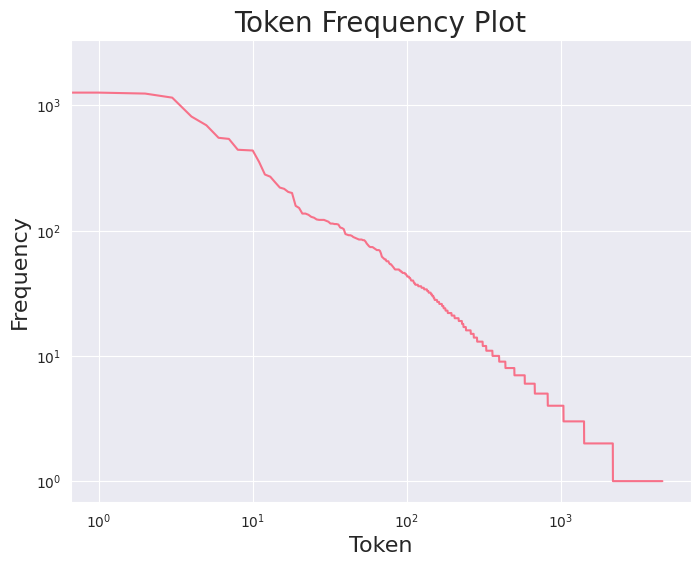

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.set_palette("husl")

freqs = [freq for token, freq in vocab.token_freqs]

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=freqs, ax=ax)
ax.set_xlabel('Token', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Token Frequency Plot', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[((4, 1), 309),
 ((8, 1), 169),
 ((2, 12), 130),
 ((2, 7), 112),
 ((3, 1), 109),
 ((1, 19), 102),
 ((11, 7), 99),
 ((6, 1), 85),
 ((14, 2), 78),
 ((4, 5), 73)]

In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[((1, 19, 71), 59),
 ((1, 19, 50), 30),
 ((1, 177, 65), 24),
 ((11, 63, 6), 16),
 ((11, 7, 5), 15),
 ((103, 3, 26), 15),
 ((63, 6, 13), 14),
 ((2, 107, 33), 14),
 ((2, 47, 1), 13),
 ((2, 110, 6), 13)]

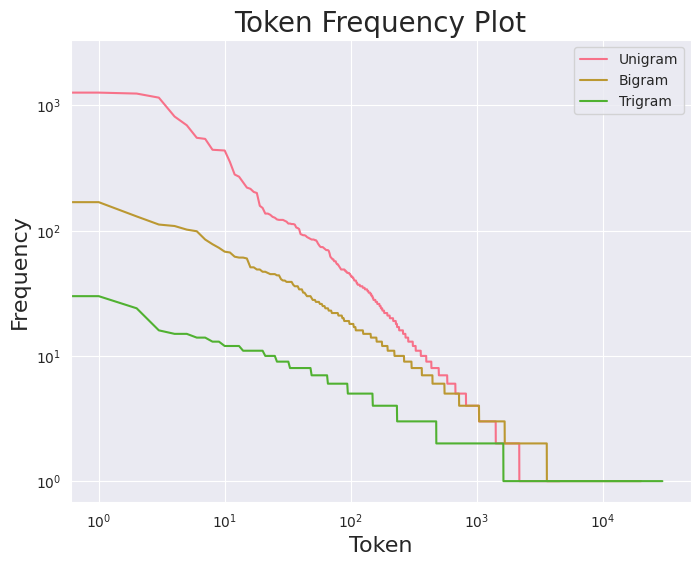

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]


fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=freqs, ax=ax,label='Unigram')
sns.lineplot(data=bigram_freqs, ax=ax,label='Bigram')
sns.lineplot(data=trigram_freqs, ax=ax,label='Trigram')
ax.set_xlabel('Token', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Token Frequency Plot', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

## Kneser-Ney smoothing

In [ ]:
from nltk.corpus import stopwords
paragraph = "Paragraphs are the building blocks of papers. Many students define paragraphs in terms of length: a paragraph is a group of at least five sentences, a paragraph is half a page long, etc. In reality, though, the unity and coherence of ideas among sentences is what constitutes a paragraph. A paragraph is defined as “a group of sentences or a single sentence that forms a unit”. Length and appearance do not determine whether a section in a paper is a paragraph. For instance, in some styles of writing, particularly journalistic styles, a paragraph can be just one sentence long. Ultimately, a paragraph is a sentence or group of sentences that support one main idea. In this handout, we will refer to this as the “controlling idea,” because it controls what happens in the rest of the paragraph."
tokens = nltk.word_tokenize(paragraph)
tokens = [w.lower() for w in tokens if w.isalpha()]
#tokens = [w for w in tokens if w not in stopwords.words("english")]

In [ ]:
from collections import Counter
from nltk.util import ngrams

trigrams = list(ngrams(tokens, 3, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
trigram_counts = Counter(trigrams)

bigrams = list(ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
bigram_counts = Counter(bigrams)

unigram_counts = Counter(tokens)


In [ ]:
d = 0.75
N1 = sum(1 for c in unigram_counts.values() if c == 1)
N = sum(unigram_counts.values())
discounts = Counter({t: d * trigram_counts[t[0:2]] / (bigram_counts[t[0:2]] + 0.01) for t in trigram_counts})
Z = sum(discounts.values())
p_continuation = Counter({w: (N1 / N) for w in unigram_counts})


In [ ]:
def trigram_prob(trigram):
    bigram_count = bigram_counts[trigram[:-1]]
    if bigram_count == 0:
        return p_continuation[trigram[-1]]
        
    else:
        pkn = max(trigram_counts[trigram] - d, 0) / bigram_count + discounts[trigram] * trigram_prob(trigram[1:])
        return pkn
test_text = [('<s>', '<s>', 'paragraphs'),('is', 'a', 'group'),('group', 'of', 'sentences')]
trigram_probs = {t: trigram_prob(t) for t in test_text}


In [ ]:
bigram_counts

In [ ]:
trigram_probs

{('<s>', '<s>', 'paragraphs'): 0.40145985401459855,
 ('is', 'a', 'group'): 0.08333333333333333,
 ('group', 'of', 'sentences'): 0.4166666666666667}

## TD-IDF weighting

In [ ]:
import math

# Define a function to compute the term frequency (TF) of a term in a document
def tf(term, document):
    return document.count(term) / len(document)

# Define a function to compute the inverse document frequency (IDF) of a term in a corpus
def idf(term, corpus):
    num_documents_with_term = sum(1 for document in corpus if term in document)
    return math.log(len(corpus) / (1 + num_documents_with_term))

# Define a function to compute the TF-IDF value of a term in a document
def tf_idf(term, document, corpus):
    return tf(term, document) * idf(term, corpus)

# Define a corpus of documents
corpus = [
    "The quick brown fox jumps over the lazy dog",
    "The brown fox is quick",
    "The lazy dog is not quick"
]

# Compute the TF-IDF values of each term in each document in the corpus
tf_idf_values = []
for document in corpus:
    document_tf_idf_values = {}
    for term in document.split():
        document_tf_idf_values[term] = tf_idf(term, document, corpus)
    tf_idf_values.append(document_tf_idf_values)

# Print the TF-IDF values for each term in each document in the corpus
for i, document_tf_idf_values in enumerate(tf_idf_values):
    print(f"Document {i+1} TF-IDF values:")
    for term, tf_idf_value in document_tf_idf_values.items():
        print(f"{term}: {tf_idf_value}")
    print()


Document 1 TF-IDF values:
The: -0.006690280754692579
quick: -0.006690280754692579
brown: 0.0
fox: 0.0
jumps: 0.00942942111879452
over: 0.00942942111879452
the: 0.00942942111879452
lazy: 0.0
dog: 0.0

Document 2 TF-IDF values:
The: -0.013076457838717314
brown: 0.0
fox: 0.0
is: 0.0
quick: -0.013076457838717314

Document 3 TF-IDF values:
The: -0.011507282898071236
lazy: 0.0
dog: 0.0
is: 0.0
not: 0.016218604324326577
quick: -0.011507282898071236



## Word2Vec

In [ ]:
class Word2VecDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.data[idx])

def collate_fn(batch):
    # Pad sequences with zeros
    max_len = max(len(seq) for seq in batch)
    padded_batch = torch.zeros(len(batch), max_len, dtype=torch.long)
    for i, seq in enumerate(batch):
        padded_batch[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)

    # Split sequences into inputs and targets
    inputs = padded_batch[:, :-1]
    targets = padded_batch[:, 1:]

    return inputs, targets

class SkipgramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipgramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size, bias=False)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        outputs = self.linear(embedded)
        return outputs

def train_skipgram(data, vocab_size, embedding_dim, batch_size=32, num_epochs=5, lr=0.01):
    # Initialize model and optimizer
    model = SkipgramModel(vocab_size, embedding_dim)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Convert data to tensor
    # Create data loader
    dataset = Word2VecDataset(data)
    dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn)

    # Train model
    for epoch in range(num_epochs):
        for i in range(0, len(data), batch_size):
            # Extract batch
            batch = data[i:i+batch_size]
            # Compute loss
            inputs = batch[:, 0]
            targets = batch[:, 1]
            inputs = inputs.to(torch.device('cpu'))
            targets = targets.to(torch.device('cpu'))
            outputs = model(inputs)
            loss = nn.functional.cross_entropy(outputs, targets)

            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Extract embeddings from embedding layer
    embeddings = model.embedding.weight.data.numpy()
    return embeddings



### Use the fist 5 sentences in the time machine to visualize the embeddings

In [ ]:
data = [line.split() for line in lines[:5]]
data_ind = [torch.tensor([vocab[s] for s in sent]) for sent in data]
#data_ind = [ind for ind in data_ind if len(ind)>0]
padded_seqs = pad_sequence(data_ind, batch_first=True, padding_value=0)
vocab_size = 4580
embedding_dim = 10

In [ ]:
padded_seqs.shape

torch.Size([5, 7])

In [ ]:
embeddings = train_skipgram(padded_seqs, vocab_size, embedding_dim)
# Get embedding for a word
word = "time"
idx = vocab[word]
embedding = embeddings[idx]
print(f"Embedding for '{word}': {embedding}")

Embedding for 'time': [ 1.351434   -0.6066669   0.10796713  0.5059124  -0.70508045 -0.42131433
 -0.00222219 -0.3635064   1.9068944   0.71708935]


## Hidden Markov Models

In [34]:
import numpy as np
from collections import defaultdict
from nltk.corpus import brown

class HiddenMarkovModel:
    def __init__(self):
        # Initialize sets for tags and words
        self.tags = set()
        self.words = set()
        # Initialize dictionaries for transition and emission probabilities
        self.transition_probs = defaultdict(lambda: defaultdict(float))
        self.emission_probs = defaultdict(lambda: defaultdict(float))

    def train(self, tagged_sentences):
        # Initialize dictionaries for tag counts and word counts per tag
        tag_counts = defaultdict(int)
        tag_word_counts = defaultdict(lambda: defaultdict(int))

        # Iterate over sentences and their corresponding tags in the dataset
        for sentence in tagged_sentences:
            prev_tag = None
            # Iterate over words and tags in a sentence
            for word, tag in sentence:
                self.words.add(word)
                self.tags.add(tag)

                # Update tag counts and word counts per tag
                tag_counts[tag] += 1
                tag_word_counts[tag][word] += 1

                # Update transition probabilities
                if prev_tag:
                    self.transition_probs[prev_tag][tag] += 1
                prev_tag = tag

        # Calculate transition probabilities
        for tag in self.tags:
            for next_tag in self.tags:
                self.transition_probs[tag][next_tag] /= tag_counts[tag]
            # Calculate emission probabilities
            for word in self.words:
                self.emission_probs[tag][word] = tag_word_counts[tag][word] / tag_counts[tag]

    def viterbi(self, sentence):
        n = len(sentence)
        m = len(self.tags)
        tags_list = list(self.tags)

        # Initialize dynamic programming table and backpointers table
        dp = np.zeros((n, m))
        backpointers = np.zeros((n, m), dtype=int)

        # Fill in the first row of the dynamic programming table
        for i, tag in enumerate(tags_list):
            dp[0][i] = self.transition_probs['<START>'][tag] * self.emission_probs[tag][sentence[0]]

        # Iterate through the rest of the sentence
        for t in range(1, n):
            for i, tag in enumerate(tags_list):
                max_prob, max_idx = 0, 0
                # Iterate over previous tags
                for j, prev_tag in enumerate(tags_list):
                    prob = dp[t - 1][j] * self.transition_probs[prev_tag][tag] * self.emission_probs[tag][sentence[t]]
                    if prob > max_prob:
                        max_prob = prob
                        max_idx = j

                # Update the dynamic programming table and backpointers table
                dp[t][i] = max_prob
                backpointers[t][i] = max_idx

        # Backtrack to find the best sequence of tags
        best_tags = []
        best_last_tag = np.argmax(dp[n - 1])
        best_tags.append(tags_list[best_last_tag])

        for i in range(n - 1, 0, -1):
            best_prev_tag = backpointers[i][best_last_tag]
            best_tags.append(tags_list[best_prev_tag])
            best_last_tag = best_prev_tag

        return list(reversed(best_tags))


['The', 'door', 'was', 'answered', 'by', 'a', 'slender', 'man', 'in', 'his', 'sixties', '--', 'straight-backed', ',', 'somewhat', 'clerical', 'in', 'manner', ',', 'wearing', 'rimless', 'glasses', '.']
['ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV']


In [35]:
%%capture
!pip install graphviz

In [54]:
from graphviz import Digraph
import random

def visualize_hmm(hmm, filename='hmm.gv'):
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    dot = Digraph('HMM', filename=filename, format='png', strict=True)
    dot.attr(rankdir='LR')

    # Add nodes for tags
    for tag in hmm.tags:
        tag_color = random_color()
        dot.node(tag, label=f'{tag}', style='filled', fillcolor=tag_color, fontsize='20')

    # Add nodes for words (with a limited number)
    words_sample = list(hmm.words)[:12]
    for word in words_sample:
        word_color = random_color()
        dot.node(f'w_{word}', label=f'{word}', shape='box', style='filled', fillcolor=word_color, fontsize='20', width='1.5', height='1')

    # Add edges for transition probabilities
    for tag1 in hmm.tags:
        for tag2 in hmm.tags:
            prob = hmm.transition_probs[tag1][tag2]
            if prob > 0.01:
                edge_color = random_color()
                dot.edge(tag1, tag2, label=f'{prob:.2f}', penwidth=f'{prob * 5}', color=edge_color, fontsize='16')

    # Add edges for emission probabilities
    for tag in hmm.tags:
        for word in words_sample:
            prob = hmm.emission_probs[tag][word]
            if prob > 0.01:
                edge_color = random_color()
                dot.edge(tag, f'w_{word}', label=f'{prob:.2f}', penwidth=f'{prob * 5}', color=edge_color, fontsize='16')

    dot.view()


In [56]:
tagged_sentences = brown.tagged_sents(tagset='universal')
hmm = HiddenMarkovModel()
hmm.train(tagged_sentences[:40000])
visualize_hmm(hmm)


In [42]:
test_sentence = [word for word, _ in tagged_sentences[40000]]
predicted_tags = hmm.viterbi(test_sentence)
print(test_sentence)
print(predicted_tags)

['The', 'door', 'was', 'answered', 'by', 'a', 'slender', 'man', 'in', 'his', 'sixties', '--', 'straight-backed', ',', 'somewhat', 'clerical', 'in', 'manner', ',', 'wearing', 'rimless', 'glasses', '.']
['ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV', 'ADV']


## Conditional Random Fields

In [58]:
%%capture
!pip install sklearn-crfsuite

In [59]:
# Install sklearn-crfsuite with: pip install sklearn-crfsuite
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from nltk.corpus import brown

def features(sentence, i):
    word = sentence[i]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    
    if i > 0:
        prev_word = sentence[i-1]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.isupper()': prev_word.isupper(),
            'prev_word.istitle()': prev_word.istitle(),
            'prev_word.isdigit()': prev_word.isdigit(),
        })
    else:
        features['BOS'] = True
        
    if i < len(sentence)-1:
        next_word = sentence[i+1]
        features.update({
            'next_word.lower()': next_word.lower(),
            'next_word.isupper()': next_word.isupper(),
            'next_word.istitle()': next_word.istitle(),
            'next_word.isdigit()': next_word.isdigit(),
        })
    else:
        features['EOS'] = True
    
    return features

def prepare_data(tagged_sentences):
    X, y = [], []
    
    for sentence in tagged_sentences:
        words, tags = zip(*sentence)
        X.append([features(words, i) for i in range(len(words))])
        y.append(tags)
    
    return X, y


Accuracy: 0.9726


In [60]:
# Load the Brown corpus with universal tagset
tagged_sentences = brown.tagged_sents(tagset='universal')
    
# Prepare data
X, y = prepare_data(tagged_sentences)
    
# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
    
# Train the CRF model
crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True,
)
crf.fit(X_train, y_train)
    
# Make predictions
y_pred = crf.predict(X_test)
    
# Evaluate the model
accuracy = metrics.flat_accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9726


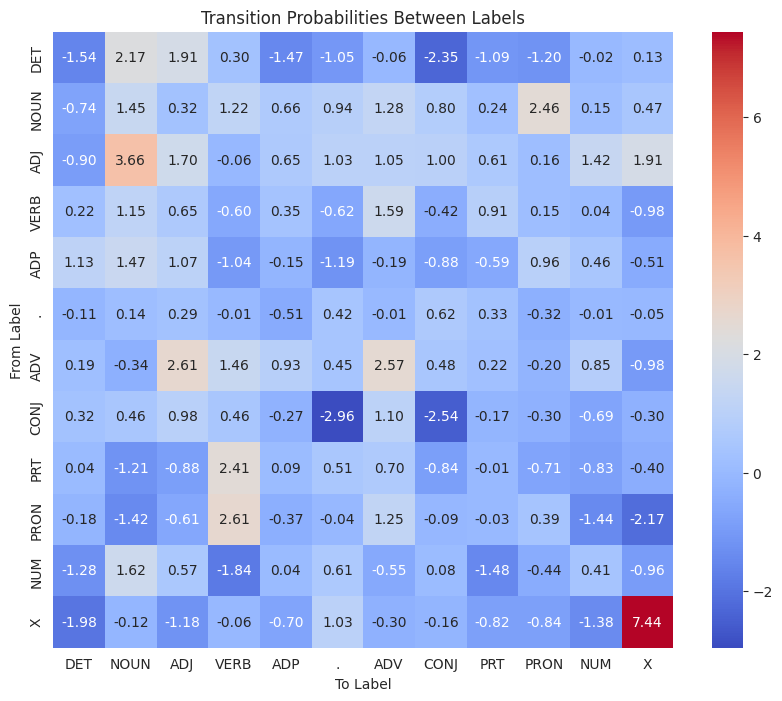

In [62]:
import seaborn as sns
import pandas as pd
def visualize_transition_probs(crf):
    labels = list(crf.classes_)
    transition_probs = np.zeros((len(labels), len(labels)))

    for i, from_label in enumerate(labels):
        for j, to_label in enumerate(labels):
            transition_probs[i][j] = crf.transition_features_[(from_label, to_label)]
    
    df_transition_probs = pd.DataFrame(transition_probs, index=labels, columns=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_transition_probs, annot=True, cmap="coolwarm", fmt=".2f")
    plt.xlabel('To Label')
    plt.ylabel('From Label')
    plt.title('Transition Probabilities Between Labels')
    plt.show()

# Visualize the transition probabilities
visualize_transition_probs(crf)
